In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings("ignore")

# Load data
csv_features = "./Dataset/acsincome_ca_features.csv"
csv_labels = "./Dataset/acsincome_ca_labels.csv"
features = pd.read_csv(csv_features)
labels = pd.read_csv(csv_labels)

# Separating features and labels, shuffling
X_all = features
Y_all = labels
X_all,Y_all = shuffle(X_all,Y_all, random_state=0)

# Only use first N samples to limit training time
sample = 0.05
num_samples = int(len(X_all)*sample)
X,Y = X_all[:num_samples], Y_all[:num_samples]

# Scaler for data standardization
scaler = StandardScaler()

# Separate train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=0, train_size=0.8)
X_train = scaler.fit_transform(X_train) 
X_test = scaler.fit_transform(X_test)

On ne standardize que les sets de feature, les labels (Y) correspondant à des booléens n'ont pas besoin d'être standardisés.

# Ada Boost

In [16]:
AB_def = AdaBoostClassifier()

AB_def.fit(X_train, Y_train)
print("Model score on test dataset :  ", AB_def.score(X_test, Y_test))
# print("Model score on train dataset : ", AB_def.score(X_train, Y_train))

Model score on test dataset :   0.7940725600408789


Model score on train dataset : 0.8127

Model score on test dataset with 1% : 0.7321

with 10% : 0.8033

with 20% : 0.8084

with 50% : 0.8061

with 100 % : 0.8063

In [3]:
score = cross_val_score(AB_def, X_train, Y_train, cv=5).mean()
print(f"Score moyen obtenu par cross validation du modèle avec les paramètres défauts : {score:.4f}")

Score moyen obtenu par cross validation du modèle avec les paramètres défauts : 0.8044


## 1. Recherche de paramètres : 

Paramètres défaut : param_def ={

    n_estimators : 50,

    learning_rate : 1.0,
    
    algorithm : SAMME.R
} 

### n_estimators

Score pour le paramètre n_estimators 300 :  0.8121648937689481
Score pour le paramètre n_estimators 400 :  0.8122926892961045
Score pour le paramètre n_estimators 500 :  0.8139534599047653
Score pour le paramètre n_estimators 600 :  0.814464397194374
Score pour le paramètre n_estimators 700 :  0.8144646420133915
Score pour le paramètre n_estimators 800 :  0.8143367648798957


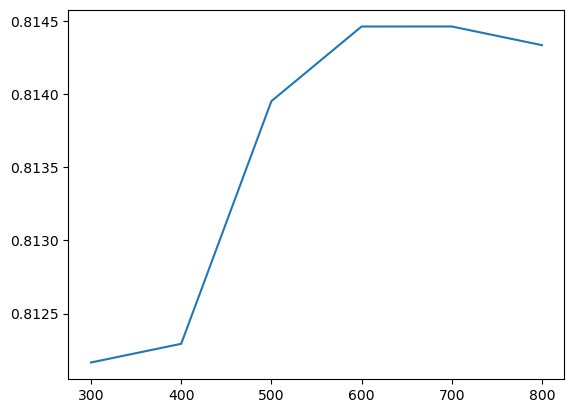

In [3]:
val_score = []
tab = [300, 400, 500, 600, 700, 800]
for n in tab:
    score = cross_val_score(AdaBoostClassifier(n_estimators=n), X_train, Y_train, cv=5).mean()
    print("Score pour le paramètre n_estimators", n, ": ",score)
    val_score.append(score)

plt.plot(tab, val_score)

Plus c'est haut mieux c'est, mais plafond à partir de 600

### Learning Rate

Score pour le paramètre learning_rate 0.1 :  0.7898032879194055
Score pour le paramètre learning_rate 0.5 :  0.8043701826757902
Score pour le paramètre learning_rate 1.0 :  0.8043702642821294
Score pour le paramètre learning_rate 2.0 :  0.4321288237670302
Score pour le paramètre learning_rate 5.0 :  0.6647001171050967
Score pour le paramètre learning_rate 10.0 :  0.6647001171050967


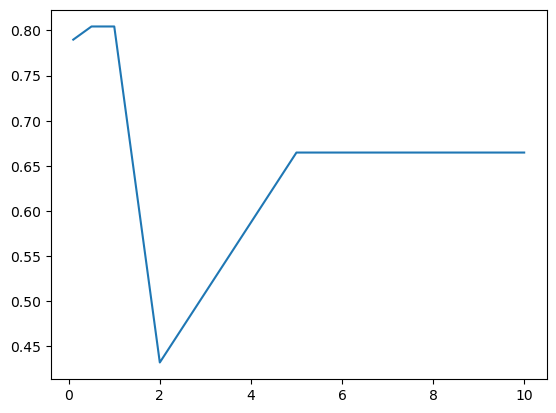

In [4]:
val_score = []
tab =[0.1, 0.5, 1.0, 2.0, 5.0, 10.0] 
for l in tab:
    score = cross_val_score(AdaBoostClassifier(learning_rate=l), X_train, Y_train, cv=5).mean()
    print("Score pour le paramètre learning_rate", l, ": ",score)
    val_score.append(score)

plt.plot(tab, val_score)

0,5, 1.0 le mieux après grosse chute

Faire attention apparemment trade-off entre n estimators et learning rate => vérifier avec gridsearch

### Algorithm

Score pour le paramètre algorithm SAMME.R :  0.8043702642821294
Score pour le paramètre algorithm SAMME :  0.8024525969177286


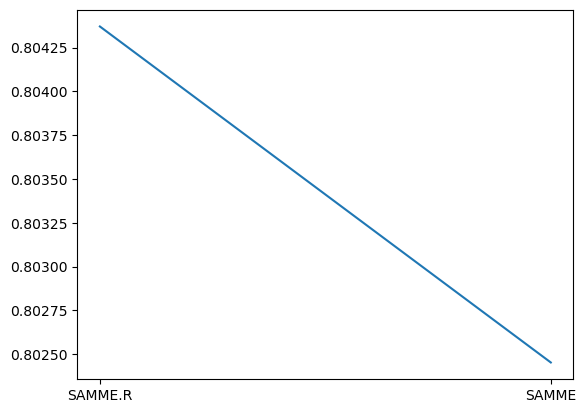

In [5]:
val_score = []
tab =['SAMME.R', 'SAMME'] 
for a in tab:
    score = cross_val_score(AdaBoostClassifier(algorithm=a), X_train, Y_train, cv=5).mean()
    print("Score pour le paramètre algorithm", a, ": ",score)
    val_score.append(score)

plt.plot(tab, val_score)

SAMME.R meilleur

## 2. Evaluation de la qualité du modèle avec les paramètres choisis

In [4]:
AB_model = AdaBoostClassifier(n_estimators=600, learning_rate=1.0, algorithm='SAMME.R')
AB_model.fit(X_train, Y_train)
print("modele entrainé")

modele entrainé


### Validation croisée

In [5]:
score = cross_val_score(AB_model, X_train, Y_train, cv=5).mean()
print(f"Score moyen obtenu par cross validation du modèle avec les paramètres sélectionnés : {score:.4f}")

Score moyen obtenu par cross validation du modèle avec les paramètres sélectionnés : 0.8145


### Accuracy

In [12]:
predictions = AB_model.predict(X_test)

res = pd.Series(predictions)
res.value_counts()

False    1164
True      793
Name: count, dtype: int64

In [13]:
accuracy = accuracy_score(Y_test, predictions)
print(f'Accuracy : {accuracy:.4f}')

Accuracy : 0.8063


### Classification report

In [14]:
report = classification_report(Y_test, predictions)
print('Classification Report y_test et predictions pour AdaBoost :\n', report)

Classification Report y_test et predictions en svm:
               precision    recall  f1-score   support

       False       0.84      0.84      0.84      1165
        True       0.76      0.76      0.76       792

    accuracy                           0.81      1957
   macro avg       0.80      0.80      0.80      1957
weighted avg       0.81      0.81      0.81      1957



### Confusion Matrix

In [15]:
conf_matrix = confusion_matrix(Y_test, predictions)
print('Confusion Matrix Y_test et predictions pour AdaBoost :\n', conf_matrix)

Confusion Matrix Y_test et predictions en svm :
 [[975 190]
 [189 603]]


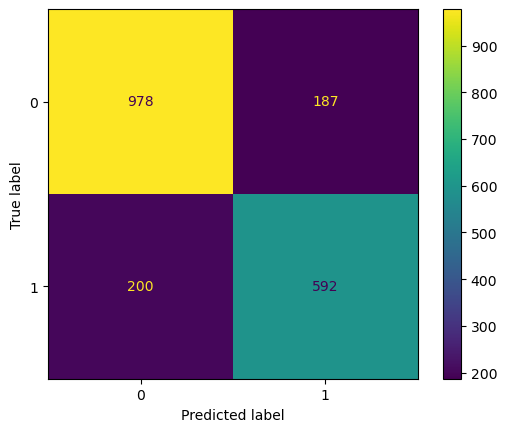

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

## 3. Gridsearch

2 min pour 1% du dataset

In [18]:
param_grid ={
    'n_estimators' :[400, 500, 600],
    'learning_rate' : [0.5, 0.8, 1.0],
    'algorithm' :['SAMME.R', 'SAMME'] 
} 
grid= GridSearchCV(estimator= AdaBoostClassifier(random_state=0),
                   param_grid=param_grid, scoring='accuracy', cv=5)

grid.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=0),
             param_grid={'algorithm': ['SAMME.R', 'SAMME'],
                         'learning_rate': [0.5, 0.8, 1.0],
                         'n_estimators': [400, 500, 600]},
             scoring='accuracy')

In [19]:
print("best score : ",grid.best_score_)

print("best parameters : ", grid.best_params_)

best score :  0.7979315147046776
best parameters :  {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 600}


In [20]:
Best_AB = grid.best_estimator_
# Best_AB = AdaBoostClassifier(algorithm="SAMME", learning_rate=1.0, n_estimators=600)

In [21]:
Best_AB.score(X_test, Y_test)

0.7678571428571429

## 4. Evaluation de la qualité du modèle avec les meilleurs hyperparamètres

### Validation croisée

validation croisée avec les meilleurs paramètres gridsearch calculés sur 1% du trainset et utilisés sur 5% du dataset

In [6]:
score = cross_val_score(AdaBoostClassifier(algorithm="SAMME", learning_rate=1.0, n_estimators=600), X_train, Y_train, cv=5).mean()
print(f"Score moyen obtenu par cross validation du modèle avec les hyperparamètres Gridsearch : {score:.4f}")

Score moyen obtenu par cross validation du modèle avec les hyperparamètres Gridsearch : 0.8110


### Accuracy

In [22]:
Best_predictions = Best_AB.predict(X_test)

Best_res = pd.Series(Best_predictions)
Best_res.value_counts()

False    266
True     126
Name: count, dtype: int64

In [23]:
Best_accuracy = accuracy_score(Y_test, Best_predictions)
print(f'Accuracy : {Best_accuracy:.4f}')

Accuracy : 0.7679


### Classification report

In [24]:
Best_report = classification_report(Y_test, Best_predictions)
print('Classification Report y_test et predictions pour AdaBoost :\n', Best_report)

Classification Report y_test et predictions en svm:
               precision    recall  f1-score   support

       False       0.74      0.90      0.81       217
        True       0.83      0.60      0.70       175

    accuracy                           0.77       392
   macro avg       0.79      0.75      0.75       392
weighted avg       0.78      0.77      0.76       392



### Confusion Matrix

In [25]:
conf_matrix = confusion_matrix(Y_test, Best_predictions)
print('Confusion Matrix Y_test et predictions pour AdaBoost :\n', conf_matrix)

Confusion Matrix Y_test et predictions en svm :
 [[196  21]
 [ 70 105]]


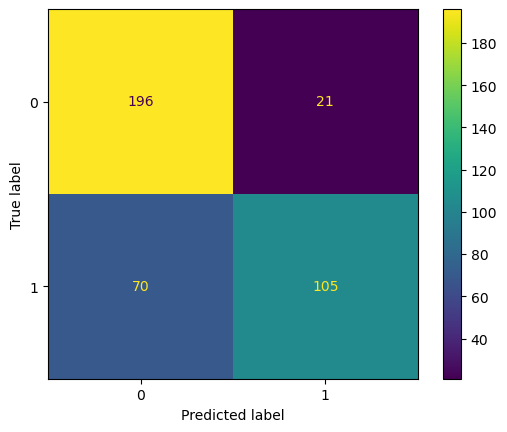

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

# Projection sur les données du Nevada et du Colorado

## 1. Nevada

In [6]:
# Load data
csv_featuresNE = "./Dataset/acsincome_ne_allfeaturesTP2.csv"
csv_labelsNE = "./Dataset/acsincome_ne_labelTP2.csv"
featuresNE = pd.read_csv(csv_featuresNE)
labelsNE = pd.read_csv(csv_labelsNE)

# Separating features and labels, shuffling
Xne_all = featuresNE
Yne_all = labelsNE
Xne_all,Yne_all = shuffle(Xne_all,Yne_all, random_state=0)

# Only use first N samples to limit training time
sample = 1
num_samples = int(len(Xne_all)*sample)
Xne,Yne = Xne_all[:num_samples], Yne_all[:num_samples]

# Scaler for data standardization
scaler = StandardScaler()

# Separate train and test sets
Xne_train, Xne_test, Yne_train, Yne_test = train_test_split(Xne,Yne, random_state=0, train_size=0.8)
Xne_train = scaler.fit_transform(Xne_train) 
Xne_test = scaler.fit_transform(Xne_test)

Pas de réentrainement des modèles, on récupère le modèle entraîné (**SVM_model**) avec les données de Californie pour appliquer le modèle aux données du Nevada et voir si cela peut permettre d'avoir de bons résultats de prédictions.

In [7]:
print("taille du dataset pour le Nevada : ", featuresNE.shape)

print("Répartition des résultats au Nevada : ", labelsNE.value_counts())

taille du dataset pour le Nevada :  (10785, 10)
Répartition des résultats au Nevada :  PINCP
0        7417
1        3368
Name: count, dtype: int64


On travaille sur 100% des données disponibles pour le Nevada car le dataset est sensiblement plus petit.

### Accuracy

In [10]:
predictionsNE = AB_model.predict(Xne_test)

res = pd.Series(predictionsNE)
res.value_counts()

False    1159
True      998
Name: count, dtype: int64

In [11]:
accuracy = accuracy_score(Yne_test, predictionsNE)
print(f'Accuracy : {accuracy:.4f}')

Accuracy : 0.7116


### Classification report

In [12]:
report = classification_report(Yne_test, predictionsNE)
print('Classification Report y_test et predictions pour svm :\n', report)

Classification Report y_test et predictions pour svm :
               precision    recall  f1-score   support

           0       0.86      0.68      0.76      1465
           1       0.54      0.77      0.63       692

    accuracy                           0.71      2157
   macro avg       0.70      0.73      0.70      2157
weighted avg       0.76      0.71      0.72      2157



### Confusion Matrix

In [13]:
conf_matrix = confusion_matrix(Yne_test, predictionsNE)
print('Confusion Matrix Y_test et predictions pour SVM :\n', conf_matrix)

Confusion Matrix Y_test et predictions pour SVM :
 [[1001  464]
 [ 158  534]]


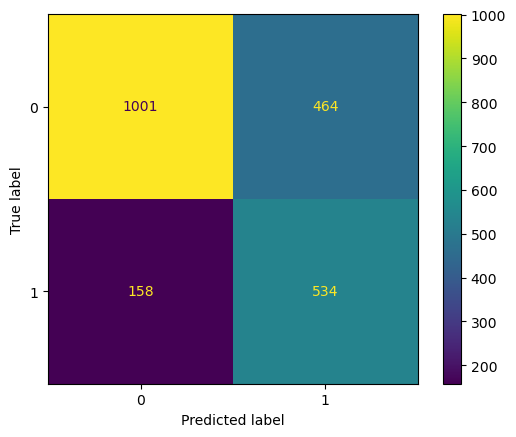

In [14]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

## 2. Colorado

In [15]:
# Load data
csv_featuresCO = "./Dataset/acsincome_co_allfeaturesTP2.csv"
csv_labelsCO = "./Dataset/acsincome_co_labelTP2.csv"
featuresCO = pd.read_csv(csv_featuresCO)
labelsCO = pd.read_csv(csv_labelsCO)

# Separating features and labels, shuffling
Xco_all = featuresCO
Yco_all = labelsCO
Xco_all,Yco_all = shuffle(Xco_all,Yco_all, random_state=0)

# Only use first N samples to limit training time
sample = 1
num_samples = int(len(Xco_all)*sample)
Xco,Yco = Xco_all[:num_samples], Yco_all[:num_samples]

# Scaler for data standardization
scaler = StandardScaler()

# Separate train and test sets
Xco_train, Xco_test, Yco_train, Yco_test = train_test_split(Xco,Yco, random_state=0, train_size=0.8)
Xco_train = scaler.fit_transform(Xco_train) 
Xco_test = scaler.fit_transform(Xco_test)

Pas de réentrainement des modèles, on récupère le modèle entraîné (**SVM_model**) avec les données de Californie pour appliquer le modèle aux données du Colorado et voir si cela peut permettre d'avoir de bons résultats de prédictions.

In [16]:
print("taille du dataset pour le Nevada : ", featuresCO.shape)

print("Répartition des résultats au Nevada : ", labelsCO.value_counts())

taille du dataset pour le Nevada :  (31306, 10)
Répartition des résultats au Nevada :  PINCP
0        18334
1        12972
Name: count, dtype: int64


On travaille sur 100% des données disponibles pour le Colorado car le dataset est sensiblement plus petit.

### Accuracy

In [17]:
predictionsCO = AB_model.predict(Xco_test)

res = pd.Series(predictionsCO)
res.value_counts()

False    3642
True     2620
Name: count, dtype: int64

In [18]:
accuracy = accuracy_score(Yco_test, predictionsCO)
print(f'Accuracy : {accuracy:.4f}')

Accuracy : 0.7676


### Classification report

In [19]:
report = classification_report(Yco_test, predictionsCO)
print('Classification Report y_test et predictions pour svm :\n', report)

Classification Report y_test et predictions pour svm :
               precision    recall  f1-score   support

           0       0.81      0.79      0.80      3719
           1       0.71      0.73      0.72      2543

    accuracy                           0.77      6262
   macro avg       0.76      0.76      0.76      6262
weighted avg       0.77      0.77      0.77      6262



### Confusion Matrix

In [20]:
conf_matrix = confusion_matrix(Yco_test, predictionsCO)
print('Confusion Matrix Y_test et predictions pour SVM :\n', conf_matrix)

Confusion Matrix Y_test et predictions pour SVM :
 [[2953  766]
 [ 689 1854]]


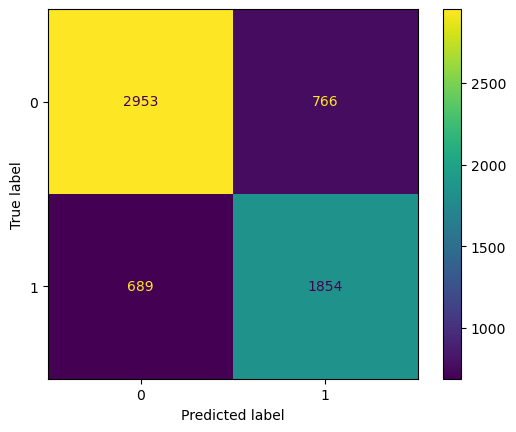

In [21]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()